[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/axr/blob/master/axr/01_bandits.ipynb)

# Frozen Lake


# Estados

# Acciones 

0: Izquierda
1: Abajo
2: Derecha
3: Arriba

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [ ]:
env = gym.make("FrozenLake-v1")
n_states = env.observation_space.n
n_actions = env.action_space.n

print("Estados:", n_states)
print("Acciones:", n_actions)


Estados: 16
Acciones: 4


## Implementación incremental

In [3]:
def q_learning(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                target = reward  # No hay estado futuro
            else:
                target = reward + gamma * np.max(Q[next_state])
            
            Q[state, action] += alpha * (target - Q[state, action])
            total_reward += reward
            state = next_state

        rewards.append(total_reward)
    return Q, rewards

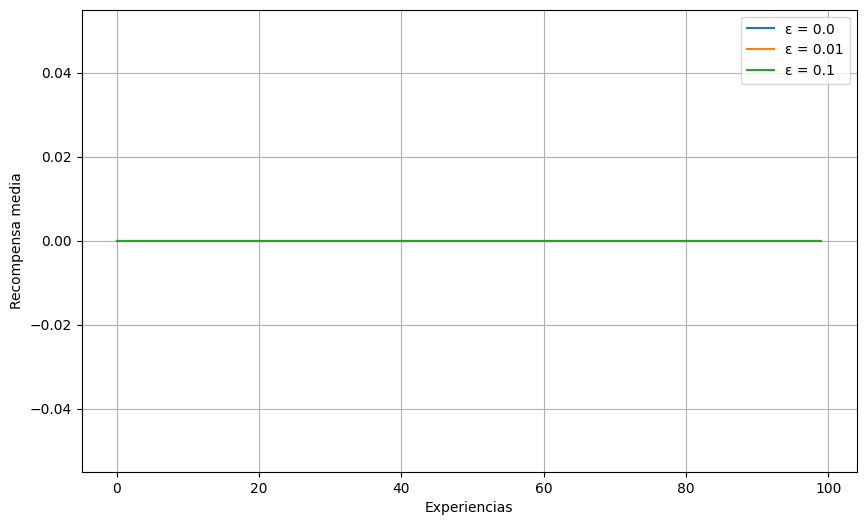

In [4]:
epsilons = [0.0, 0.01, 0.1]

# Ejecutar y graficar
plt.figure(figsize=(10, 6))

for eps in epsilons:
    Q, rewards = q_learning(env, episodes=100, epsilon=eps)
    plt.plot(rewards, label=f'ε = {eps}')

plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
import time

print("🎮 Entrenando agente...")
Q_trained, training_rewards = q_learning(env, episodes=500, epsilon=0.01)
print(f"✅ Entrenamiento completado! Recompensa final: {np.mean(training_rewards[-50:]):.2f}")

def visualize_agent_playing(env, Q, num_games=3, delay=1.0):
    """
    Visualiza al agente jugando paso a paso
    """
    actions_names = ['↑ Arriba', '→ Derecha', '↓ Abajo', '← Izquierda']
    
    for game in range(num_games):
        print(f"\n{'='*50}")
        print(f"🎮 JUEGO {game + 1}")
        print(f"{'='*50}")
        
        state, _ = env.reset()
        done = False
        total_reward = 0
        step = 0
        
        # Crear representación visual del grid 4x12
        def print_grid(current_state):
            grid = [['.' for _ in range(12)] for _ in range(4)]
            
            # Marcar precipicio (estados 37-46)
            for i in range(37, 47):
                row = i // 12
                col = i % 12
                grid[row][col] = '💀'
            
            # Marcar inicio (estado 36)
            row, col = 3, 0
            grid[row][col] = '🏠'
            
            # Marcar objetivo (estado 47)
            row, col = 3, 11
            grid[row][col] = '🎯'
            
            # Marcar posición actual del agente
            row = current_state // 12
            col = current_state % 12
            if current_state not in [36, 47] and not (37 <= current_state <= 46):
                grid[row][col] = '🤖'
            
            # Imprimir grid
            print("\n   0123456789AB")  # Columnas
            for i, row in enumerate(grid):
                print(f"{i}  {''.join(row)}")
            print()
        
        while not done:
            # Mostrar estado actual
            print(f"\n⏰ Paso {step + 1}")
            print(f"📍 Estado actual: {state}")
            print_grid(state)
            
            # Mostrar valores Q para este estado
            q_values = Q[state]
            print("🧠 Valores Q del agente:")
            for i, (action_name, q_val) in enumerate(zip(actions_names, q_values)):
                marker = "👉" if i == np.argmax(q_values) else "  "
                print(f"   {marker} {action_name}: {q_val:.3f}")
            
            
            action = np.argmax(Q[state])
            chosen_action = actions_names[action]
            
            print(f"\n🎯 Agente elige: {chosen_action}")
            
            # Ejecutar acción
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            print(f"🏆 Recompensa: {reward}")
            print(f"➡️  Nuevo estado: {next_state}")
            
            # Análisis de la decisión
            if reward == -100:
                print("💥 ¡CAYÓ AL PRECIPICIO! Regresa al inicio.")
            elif terminated and reward == -1:
                print("🎉 ¡LLEGÓ AL OBJETIVO! Episodio completado.")
            else:
                print("✅ Paso normal, continúa...")
            
            total_reward += reward
            step += 1
            state = next_state
            
            # Pausa para visualización
            time.sleep(delay)
            
            # Limpiar pantalla (opcional)
            # os.system('cls' if os.name == 'nt' else 'clear')
        
        print(f"\n🏁 RESULTADO DEL JUEGO {game + 1}:")
        print(f"   Total pasos: {step}")
        print(f"   Recompensa total: {total_reward}")
        print(f"   {'🎉 ÉXITO' if total_reward >= -20 else '💥 FALLÓ'}")
        
        input("\n⏸️  Presiona ENTER para el siguiente juego...")

def analyze_learned_policy(env, Q):
    """
    Analiza la política aprendida estado por estado
    """
    actions_names = ['↑', '→', '↓', '←']
    print(f"\n{'='*60}")
    print("🧠 ANÁLISIS DE LA POLÍTICA APRENDIDA")
    print(f"{'='*60}")
    
    # Crear mapa de política
    policy_grid = [['?' for _ in range(12)] for _ in range(4)]
    
    for state in range(env.observation_space.n):
        row = state // 12
        col = state % 12
        best_action = np.argmax(Q[state])
        
        # Estados especiales
        if state == 36:  # Inicio
            policy_grid[row][col] = '🏠'
        elif state == 47:  # Objetivo
            policy_grid[row][col] = '🎯'
        elif 37 <= state <= 46:  # Precipicio
            policy_grid[row][col] = '💀'
        else:
            policy_grid[row][col] = actions_names[best_action]
    
    print("\nMapa de la política (acción preferida en cada estado):")
    print("🏠=Inicio, 🎯=Objetivo, 💀=Precipicio")
    print("\n   0123456789AB")
    for i, row in enumerate(policy_grid):
        print(f"{i}  {''.join(f'{cell:>2}' for cell in row)}")

# 3. USAR LAS FUNCIONES CON TU AGENTE ENTRENADO
print("🎬 Visualizando agente entrenado jugando...")

# Primero analizar la política
analyze_learned_policy(env, Q_trained)

# Luego ver al agente jugando
visualize_agent_playing(env, Q_trained, num_games=3, delay=1.5)  

🎮 Entrenando agente...
✅ Entrenamiento completado! Recompensa final: 0.00
🎬 Visualizando agente entrenado jugando...

🧠 ANÁLISIS DE LA POLÍTICA APRENDIDA

Mapa de la política (acción preferida en cada estado):
🏠=Inicio, 🎯=Objetivo, 💀=Precipicio

   0123456789AB
0   ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑
1   ↑ ↑ ↑ ↑ ? ? ? ? ? ? ? ?
2   ? ? ? ? ? ? ? ? ? ? ? ?
3   ? ? ? ? ? ? ? ? ? ? ? ?

🎮 JUEGO 1

⏰ Paso 1
📍 Estado actual: 0

   0123456789AB
0  🤖...........
1  ............
2  ............
3  🏠💀💀💀💀💀💀💀💀💀💀🎯

🧠 Valores Q del agente:
   👉 ↑ Arriba: 0.000
      → Derecha: 0.000
      ↓ Abajo: 0.000
      ← Izquierda: 0.000

🎯 Agente elige: ↑ Arriba
🏆 Recompensa: 0.0
➡️  Nuevo estado: 4
✅ Paso normal, continúa...

⏰ Paso 2
📍 Estado actual: 4

   0123456789AB
0  ....🤖.......
1  ............
2  ............
3  🏠💀💀💀💀💀💀💀💀💀💀🎯

🧠 Valores Q del agente:
   👉 ↑ Arriba: 0.000
      → Derecha: 0.000
      ↓ Abajo: 0.000
      ← Izquierda: 0.000

🎯 Agente elige: ↑ Arriba
🏆 Recompensa: 0.0
➡️  Nuevo estado: 4
✅ Paso nor